# sofa

The purpose of this notebook is to try out some initial explorations
of the moving sofa problem.

## Imports

In [9]:
import numpy as np
from PIL import Image, ImageDraw

In [43]:
from IPython.display import display

## Learn how to make and show a simple image

In [10]:
np_arr = np.zeros((200, 200, 3))

In [12]:
im = Image.fromarray(np_arr.astype(np.uint8))

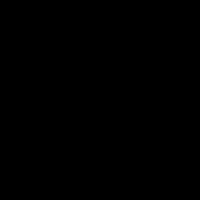

In [14]:
im

In [48]:
# Let's make a 20-pixel-wide hallway corner.

HALLWAY_WIDTH = 20

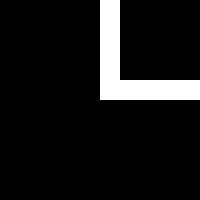

In [50]:
# Let's make a 20-pixel-wide hallway corner.

x_lo = 100
x_hi = lo + HALLWAY_WIDTH

y_lo = 100 - HALLWAY_WIDTH
y_hi = 100

np_arr = np.zeros((200, 200, 3))
np_arr[y_lo:y_hi, x_lo:] = 255
np_arr[:y_hi, x_lo:x_hi] = 255
im = Image.fromarray(np_arr.astype(np.uint8))
im

# Learn how to rotate an image

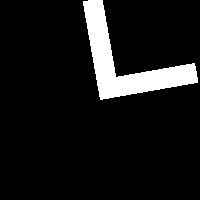

In [51]:
im.rotate(10)

# Learn how to take the intersection of two images

In [52]:
np_arr = np.asarray(im).astype(np.float32) / 255
np.min(np_arr), np.max(np_arr)

(0.0, 1.0)

In [53]:
def to_array(im):
    return np.asarray(im).astype(np.float32) / 255

In [54]:
def to_im(arr):
    return Image.fromarray((arr * 255).astype(np.uint8))

In [55]:
def intersect_images(im1, im2):
    arr1 = to_array(im1)
    arr2 = to_array(im2)
    return to_im(arr1 * arr2)

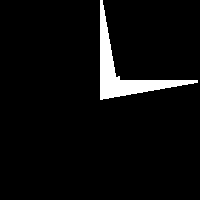

In [56]:
intersect_images(im, im.rotate(10))

## Be able to find the intersection of an arbitrary rotate around an arbitrary point

In [47]:
im.size

(200, 200)

In [57]:
def find_next_intersection(pos, isect, angle, center):
    ''' This accepts the following parameters:
        * pos    = The hallway in its current position; an Image object.
        * isect  = The intersection of all previous steps; an Image object.
        * angle  = The angle, in degrees (with apologies), of the rotation.
        * center = The center of rotation. (0, 0) is the original outside corner.
                   (1, 1) is the original inside corner.
    '''
    
    # Convert the center to image-based coordinates.
    w, h = im.size
    center = (
        w // 2 - center[1] * HALLWAY_WIDTH,
        h // 2 + center[0] * HALLWAY_WIDTH
    )
    
    # XXX This whole function while I write it.
    
    print()
    print('pos:')
    display(pos)
    
    print()
    print('isect:')
    display(isect)
    
    num_steps = 3
    
    for i in range(num_steps):
        pos = pos.rotate(angle / num_steps, center=center)
        print('\npos:'); display(pos)
        isect = intersect_images(isect, pos)
        print('\nisect:'); display(isect)
    
    


pos:


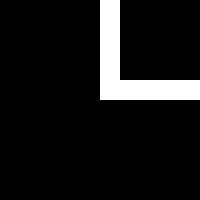


isect:


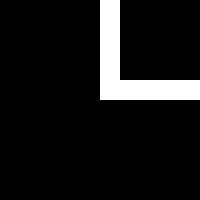


pos:


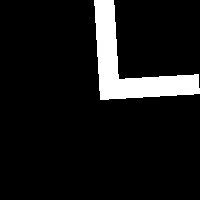


isect:


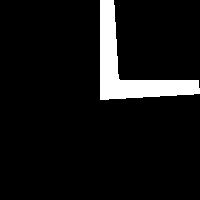


pos:


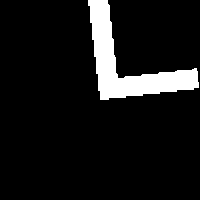


isect:


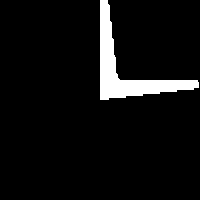


pos:


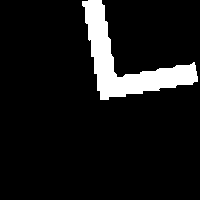


isect:


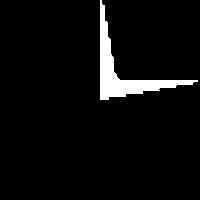

In [58]:
find_next_intersection(im, im, 10, (0, 0))

### Notes

Ok, there's a problem with this approach. What's happening is that
I'm losing image integrety as I iteratively rotate it.

As a digression, it might be interesting to study the patterns that
naturally arise by doing this. However, I think a better approach
here is to keep track of a single cumulative transformation matrix,
and to always use that to generate a current-position hallway
image each time we take the intersection with it.

## Be able to dynamically generate a hallway image from a transformation matrix

The hallway will be a polygon between these points, going counterclockwise
in the Cartesian plane:

    (0, 0) -- (A, 0) -- (A, 1) -- (1, 1) -- (1, A) -- (0, A) -- [close]

Here, `A` is some large enough value that I think is mostly unimportant.
I'm guessing a value as low as 3 would suffice. (If we find all optimal shapes,
then we can say with certainty exactly how large `A` really needs to be.)

I'll think of each of those 2d points $p=(x, y)$ as a column vector
$\begin{pmatrix}x \\ y \\ 1 \end{pmatrix}$, and then we can use a transformation matrix
$T$ by mapping $p$ to $Tp$.

A rotation by $\theta$ radians around the origin is given by

$$ T = \begin{pmatrix} \cos\theta & -\sin\theta & 0 \\
\sin\theta & \cos\theta & 0 \\
0 & 0 & 1 \\
\end{pmatrix}. $$

A rotation around $(x, y)$ can be achieved by (i) translating
$(x, y)$ to the origin; (ii) rotating around the origin, and then (iii)
translating the origin back to $(x, y)$.

In [62]:
def to_col(p):
    return np.array(list(p) + [1]).reshape(3, 1)

In [63]:
to_col([10, 20])

array([[10],
       [20],
       [ 1]])

In [68]:
# Be able to draw a polygon in an image.

np_arr = np.zeros((200, 200, 3))
im = Image.fromarray(np_arr.astype(np.uint8))
draw = ImageDraw.Draw(im)
draw.polygon([(10, 10), (20, 100), (100, 40)], fill='white')

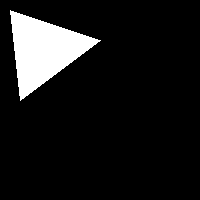

In [69]:
im

In [85]:
# Define transformation primitives.
# I'll start these all with `tr_` for 'transformation'.

# Rotation.
def tr_rot(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0            , 0             , 1]
    ])

# Translation.
def tr_add(x, y):
    return np.array([
        [1, 0, x],
        [0, 1, y],
        [0, 0, 1]
    ])

# Scale.
def tr_scl(s):
    return np.array([
        [s, 0, 0],
        [0, s, 0],
        [0, 0, 1]
    ])

In [134]:
PIXEL_SIZE = 200

def make_transformed_hallway(T):
    ''' This returns the image of the hallway once transformation T is applied. '''
    
    A = 30
    
    pts = list(map(to_col, [
        [0, 0],
        [A, 0],
        [A, 1],
        [1, 1],
        [1, A],
        [0, A]
    ]))
    
    # After applying the mathematical transformation T, we'll also
    # convert the points from Cartesian coordinates to pixel coords.
    
    mid = (PIXEL_SIZE - HALLWAY_WIDTH) // 2
    to_pixels = tr_add(mid, mid).dot(tr_scl(HALLWAY_WIDTH))
    T = to_pixels.dot(T)
    
    for i in range(len(pts)):
        pts[i] = tuple(T.dot(pts[i]).reshape(3)[:2])
        
    np_arr = np.zeros((200, 200, 3))
    im = Image.fromarray(np_arr.astype(np.uint8))
    draw = ImageDraw.Draw(im)
    draw.polygon(pts, fill='white')
    
    return im

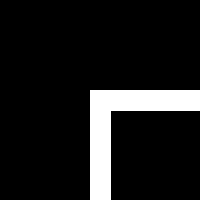

In [135]:
make_transformed_hallway(np.eye(3))

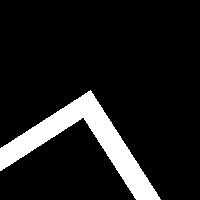

In [136]:
make_transformed_hallway(tr_rot(1))

In [137]:
# Test a rotation around (1, 1).

# "Spin", meaning a rotation around a given point.
def tr_spn(theta, x, y):
    return tr_add(x, y).dot(tr_rot(theta).dot(tr_add(-x, -y)))

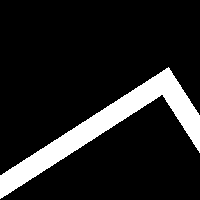

In [138]:
make_transformed_hallway(tr_spn(1, 3, 3))